## Import datas

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [4]:
# Use pandas to loadinto a DataFrame
# Y1.csv doesn’t have a header so
# add one when loading the file
X1 = pd.read_csv("data/X1.csv")
Y1 = pd.read_csv("data/Y1.csv", header=None, names=['revenue'])


# ENLEVER colonne "Unnamed" du dataset : utilité ? -> Pas listé dans les features du pdf
X = X1.drop(['Unnamed: 0', 'img_url', 'description'], axis=1)

### Pre data visualisation

In [5]:
"""
print(X.describe())

plt.figure(figsize=(7,4))
corr = X.corr(numeric_only=True)
heatmap = sns.heatmap(corr, annot=True, cmap="coolwarm", fmt='.1g')
"""

'\nprint(X.describe())\n\nplt.figure(figsize=(7,4))\ncorr = X.corr(numeric_only=True)\nheatmap = sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=\'.1g\')\n'

## Preprocessing the data
### Preprocessing functions

In [6]:
"""
Creating empty DataFrame to start
"""
n_samples = X.shape[0]
data = pd.DataFrame()

In [7]:
"""
Keeping the directly usable features
"""
def get_directrly_usable_features(df):
    directly_usable_features = ["ratings", "n_votes", "is_adult"]
    for feature in directly_usable_features:
        df[feature] = X[feature]

    df["normalized_ratings"] = (X["n_votes"] - X["n_votes"].min()) / (X["n_votes"].max() - X["n_votes"].min())
    return df

In [8]:
"""
Dealing with the "production_year" feature
"""

def get_prod_year_feature(df, params):
    
    style = params["production_year_style"] # "per_quantile" / "per_period_length" / "no_period"
    if style != "no_period" :
        n_year_period = params["n_year_period"]

    # Removing previously computed categorie(s) for the "production_year" initial feature

    for feature in df.columns:
        if len(feature) >= 8 and (feature[:6] == "period" or feature == "production_year"):
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "production_year" initial feature

    prod_year = X["production_year"].copy()
    if style == "per_quantile" or style == "per_period_length":
        categories = np.ones((n_year_period, n_samples))

        if style == "per_quantile":
            thresholds = prod_year.quantile(np.arange(1, n_year_period) / n_year_period)
        else :
            thresholds = np.min(prod_year) + (np.max(prod_year) - np.min(prod_year))*np.arange(1, n_year_period)/n_year_period
        for i, threshold in enumerate(thresholds):
            categories[i+1] = (prod_year >= threshold).astype(int)
            categories[i] -= categories[i+1]
        for period in range(n_year_period):
            df["period {}".format(period)] = categories[period]
    elif style == "no_period":
        df["production_year"] = prod_year
    return df

In [9]:
"""
Dealing with the "runtime" feature

The problem is here that we have some missing values, we have to deal with it.
"""

def get_runtime_feature(df, params):

    # Add other smarter ways ?
    
    replace_type = params["runtime_replace_type"] # "zero" / "mean"
    
    runtime = X["runtime"].copy()
    if replace_type == "zero":
        runtime[runtime == "\\N"] = 0
    if replace_type == "mean":
        mean = np.mean(runtime[runtime != "\\N"].astype(float))
        runtime[runtime == "\\N"] = mean
    if replace_type == "median":
        median = np.median(runtime[runtime != "\\N"].astype(float))
        runtime[runtime == "\\N"] = median
    df["runtime"] = runtime.astype(float)    
    return df

In [10]:
import copy
"""
Dealing with the "studio" feature


Juste rajouter toute les features une par une me semblait un peu lourd (yen a 509), ducoup j'effectue PCA dessus.
Jsp si ça se fait ? (on peut changer l'algo de dimensionality reduction aussi si on veut)
"""

def get_studio_feature(df, params):
    use_PCA = params["studio_use_PCA"]
    if use_PCA :
        dim = params["studio_PCA_dim"]

    # Removing previously computed categorie(s) for the "studio" initial feature
    for feature in df.columns:
        if len(feature) >= 10 and feature[:10] == "studio_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "studio" initial feature
    studio = copy.deepcopy(X["studio"])
    studio_labels = np.unique(studio)
    studio_features = np.zeros((len(studio_labels), n_samples))
    for i, label in enumerate(studio_labels) :
        studio_features[i] = (studio == label).astype(int)
    
    # Applying pca or not
    if use_PCA :
        pca = PCA(n_components=dim)
        out = pca.fit_transform(studio_features.T)
    else :
        normals = studio_features[np.count_nonzero(studio_features, axis=1) > 5].T
        outliers = np.sum(studio_features[np.count_nonzero(studio_features, axis=1) <= 5].T, axis = 1)
        out = np.zeros((normals.shape[0], normals.shape[1] + 1))
        out[:, :-1] = normals
        out[:, -1] = outliers
        dim = out.shape[1]
    
    df[["studio_PC_{}".format(i) for i in range(dim)]] = out
    return df

# Ya plein de warnings quand dim trop grand ou pas de PCA /: 
# jsp comment regler ça... en utilisant pd.concat ça tourne vraiment extrêmement lentement

In [11]:
"""
Dealing with the "genres" feature

Je rajoute juste une feature par genre, j'espère ça suffit ? -> pt-être dimension reduction sur ça aussi ?
Certains films ont pas de genre attitré (genre = "\\N"),
ce que j'ai fait ici considère ça comme un genre à part entière, ptet on peut deal le truc autrement ?
"""

def get_genre_feature(df):

    X.loc[X["genres"] == "\\N", "genres"] = "Others"
    all_genres = X["genres"].copy()
    diff_genres = []

    for genres in np.unique(all_genres):
        for genre in genres.split(",") :
            if not genre in diff_genres :
                diff_genres.append(genre)

    for genre in diff_genres:
        df[genre] = [1 if genre in genres.split(",") else 0 for genres in all_genres]  
    return df

In [12]:
"""
Dealing with the "text_embeddings" feature


Dimension of embedding space is too high -> dimensionnality reduction
J'utilise que PCA pr l'instant ici aussi
"""
def get_text_embedding_feature(df, params):
    
    output_dim = params["text_embedding_PCA_dim"] # output dimension of PCA

    # Removing previously computed categorie(s) for the "text_embedding" initial feature
    for feature in df.columns:
        if len(feature) >= 18 and feature[:18] == "text_embedding_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "text_embedding" initial feature
    text_embeddings = X["text_embeddings"]
    input_dim = 768
    embeddings = np.zeros((n_samples, input_dim))
    for i, text_embedding in enumerate(text_embeddings):
        embeddings[i] = list(map(float,text_embedding[1:-1].split(",")))

    # applying PCA
    pca = PCA(n_components=output_dim)
    output = pca.fit_transform(embeddings)

    df[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output
    return df

In [13]:
"""
Dealing with the "img_embeddings" feature


Dimension of embedding space is too high -> dimensionnality reduction
J'utilise que PCA pr l'instant ici aussi
"""
def get_img_embedding_feature(df, params):
    output_dim = params["img_embedding_PCA_dim"] # output dimension of PCA

    # Removing previously computed categorie(s) for the "img_embedding" initial feature
    for feature in df.columns:
        if len(feature) >= 17 and feature[:17] == "img_embedding_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "img_embedding" initial feature
    img_embeddings = X["img_embeddings"]
    input_dim = 2048
    embeddings = np.zeros((n_samples, input_dim))
    for i, img_embedding in enumerate(img_embeddings):
        embeddings[i] = list(map(float,img_embedding[1:-1].split(",")))

    # applying PCA
    pca = PCA(n_components=output_dim)
    output = pca.fit_transform(embeddings)

    df[["img_embedding_PC_{}".format(i) for i in range(output_dim)]] = output
    return df

In [14]:
def create_preprocessed(params):
    df = pd.DataFrame()
    df = get_genre_feature(df)
    df = get_directrly_usable_features(df)
    df = get_prod_year_feature(df, params)
    df = get_studio_feature(df, params)
    df = get_runtime_feature(df, params)
    df = get_text_embedding_feature(df, params)
    df = get_img_embedding_feature(df, params)
    return df

In [15]:
def create_preprocessed_dict(params):
    final = {}
    year_dict = {}
    for val1 in params["production_year_style"] :
        for val2 in params["n_year_period"] :
            tmp = {}
            tmp["production_year_style"] = val1
            tmp["n_year_period"] = val2
            year_dict[val1+str(val2)] = get_prod_year_feature(pd.DataFrame(), tmp)
    final["year"] = year_dict
    
    studio_dict = {}
    for val1 in params["studio_use_PCA"] :
        for val2 in params["studio_PCA_dim"] :
            tmp = {}
            tmp["studio_use_PCA"] = val1
            tmp["studio_PCA_dim"] = val2
            studio_dict[str(val1)+str(val2)] = get_studio_feature(pd.DataFrame(), tmp)
    final["studio"] = studio_dict
    
    runtime_dict = {}
    for val in params["runtime_replace_type"] :
        tmp = {}
        tmp["runtime_replace_type"] = val
        runtime_dict[val] = get_runtime_feature(pd.DataFrame(), tmp)
    final["runtime"] = runtime_dict
    
    text_dict = {}
    for val in params["text_embedding_PCA_dim"] :
        tmp = {}
        tmp["text_embedding_PCA_dim"] = val
        text_dict[val] = get_text_embedding_feature(pd.DataFrame(), tmp)
    final["text"] = text_dict
    
    img_dict = {}
    for val in params["img_embedding_PCA_dim"] :
        tmp = {}
        tmp["img_embedding_PCA_dim"] = val
        img_dict[val] = get_img_embedding_feature(pd.DataFrame(), tmp)
    final["img"] = img_dict   
    final["genre"] = get_genre_feature(pd.DataFrame())
    final["base"] = get_directrly_usable_features(pd.DataFrame())
    return final

In [16]:
def create_preprocessed_from_dict(params_dict, params):
    frames = []
    frames.append(params_dict["genre"])
    frames.append(params_dict["base"])
    frames.append(params_dict["year"][params["production_year_style"] + str(params["n_year_period"])])
    frames.append(params_dict["studio"][str(params["studio_use_PCA"]) + str(params["studio_PCA_dim"])])
    frames.append(params_dict["runtime"][params["runtime_replace_type"]])
    frames.append(params_dict["text"][params["text_embedding_PCA_dim"]])
    frames.append(params_dict["img"][params["img_embedding_PCA_dim"]])
    return pd.concat(frames, axis=1)

### Preprocessing execution

In [17]:
"""
Example of data preprocessing
"""

params = {
    "production_year_style" : "per_quantile", # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : 5,
    "runtime_replace_type" : "mean", # "mean" / "zero" / "median"
    "studio_use_PCA" : True,
    "studio_PCA_dim" : 50,
    "text_embedding_PCA_dim" : 50,
    "img_embedding_PCA_dim" : 50
}

preprocessed_data = create_preprocessed(params)

In [18]:
"""
all_params = {
    "production_year_style" : ["per_quantile", "per_period_length", "no_period"], # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : [3, 5, 10],
    "runtime_replace_type" : ["mean", "zero"], # "mean" / "zero" / "median"
    "studio_use_PCA" : [True],
    "studio_PCA_dim" : [1, 10],
    "text_embedding_PCA_dim" : [1, 10],
    "img_embedding_PCA_dim" : [1, 10]
}

params = {
    "production_year_style" : "per_quantile", # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : 5,
    "runtime_replace_type" : "mean", # "mean" / "zero"
    "studio_use_PCA" : True,
    "studio_PCA_dim" : 1,
    "text_embedding_PCA_dim" : 10,
    "img_embedding_PCA_dim" : 10
}

preprocessed_dict = create_preprocessed_dict(all_params)
preprocessed_data = create_preprocessed_from_dict(preprocessed_dict, params)
preprocessed_data_2 = create_preprocessed(params)
"""

'\nall_params = {\n    "production_year_style" : ["per_quantile", "per_period_length", "no_period"], # "per_quantile" / "per_period_length" / "no_period"\n    "n_year_period" : [3, 5, 10],\n    "runtime_replace_type" : ["mean", "zero"], # "mean" / "zero" / "median"\n    "studio_use_PCA" : [True],\n    "studio_PCA_dim" : [1, 10],\n    "text_embedding_PCA_dim" : [1, 10],\n    "img_embedding_PCA_dim" : [1, 10]\n}\n\nparams = {\n    "production_year_style" : "per_quantile", # "per_quantile" / "per_period_length" / "no_period"\n    "n_year_period" : 5,\n    "runtime_replace_type" : "mean", # "mean" / "zero"\n    "studio_use_PCA" : True,\n    "studio_PCA_dim" : 1,\n    "text_embedding_PCA_dim" : 10,\n    "img_embedding_PCA_dim" : 10\n}\n\npreprocessed_dict = create_preprocessed_dict(all_params)\npreprocessed_data = create_preprocessed_from_dict(preprocessed_dict, params)\npreprocessed_data_2 = create_preprocessed(params)\n'

In [19]:
# preprocessed_data.head()

In [20]:
# preprocessed_data_2.head()

### Data visualisation

In [21]:
"""
plt.figure(figsize=(12,8))
corr = preprocessed_data.corr()

heatmap = sns.heatmap(corr, cmap="coolwarm"
"""

'\nplt.figure(figsize=(12,8))\ncorr = preprocessed_data.corr()\n\nheatmap = sns.heatmap(corr, cmap="coolwarm"\n'

### Feature Selection


In [22]:
# Creer un data training/validation splités a partir du X1 (on garde X2 pour les vrais tests) 
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, Y1, test_size = 0.2, random_state=0)

In [23]:
# Score computation : Root Mean Square Error

def compute_rmse(predict, target):
    return -mean_squared_error(predict, target, squared=False)

def compute_rmse2(predict, target):
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

custom_scorer = make_scorer(compute_rmse)

In [24]:
def perform_rand_search(model_, params, scoring, X_train, y_train):
    grid = RandomizedSearchCV(model_, params, cv=5, scoring=scoring, n_jobs=-1)
    grid.fit(X_train,y_train)
    print("grid.best_score_: ", grid.best_score_)
    print("grid.best_params_: ",grid.best_params_)
    return grid
 

In [25]:
def perform_grid_search(model_, params, scoring, X_train, y_train):

    grid = GridSearchCV(model_, params, cv=5, scoring=scoring, n_jobs=-1)
    grid.fit(X_train,y_train)
    print("grid.best_score_: ", grid.best_score_)
    print("grid.best_params_: ",grid.best_params_)
    return grid
 

In [26]:
scores = mutual_info_regression(X_train, np.ravel(y_train))

### Linear Regression

In [27]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
model.predict(X_test)

# Évaluez le modèle en utilisant le scoreur personnalisé
score = custom_scorer(model, X_test, y_test)
print("RMSE Score: %.2f$" % score)
print("Score: %.2f%%" %model.score(X_test, y_test))

# Évaluez le modèle en utilisant le cross_val
rmse_score = cross_val_score(LinearRegression(), preprocessed_data, Y1.values.ravel(), cv=5, scoring=custom_scorer)
linear_regressor_score = cross_val_score(LinearRegression(), preprocessed_data, Y1.values.ravel(), cv=5)
print("\nCV RMSE Score : %.2f$" % np.mean(rmse_score))
print("CV Score : %.2f%%" % np.mean(linear_regressor_score))

RMSE Score: -53069175.74$
Score: 0.47%

CV RMSE Score : -57023226.95$
CV Score : 0.39%


In [65]:
import copy
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV



class Solution:
    def __init__(self, params, grid_params, score):
        self.grid_params = grid_params
        self.params = params
        self.score = score

class LocalSearch :
    
    def __init__(self, regressor, params, grid_params):
        self.curr_score = []
        self.best_score = []
        self.regressor = regressor
        self.params = params
        self.preprocessed_dict = create_preprocessed_dict(params)
        self.grid_params = grid_params
        self.visited = []

    
    def clean(self, params):
        copied = copy.deepcopy(params)
        if copied["production_year_style"] == "no_period":
            copied.pop("n_year_period")
        if copied["studio_use_PCA"] == False:
            copied.pop("studio_PCA_dim")
        return copied
    
    def is_visited(self, params):
        return str(self.clean(params)) in self.visited
    
    def visit(self, params):
        self.visited.append(str(self.clean(params)))
    
    def get_solution(self, params):
        preprocessed_data = copy.deepcopy(create_preprocessed_from_dict(self.preprocessed_dict, params))
        grid_search = RandomizedSearchCV(regressor, self.grid_params, cv=5, scoring=custom_scorer, n_jobs=-1, random_state=0)
        grid_search.fit(preprocessed_data, Y1)
        current_score = np.mean(grid_search.best_score_)
        self.visit(params)
        return Solution(params, grid_search.best_params_, current_score)
    
    def initiate(self):
        current_params = {}
        for param in self.params.keys():
            current_params[param] = np.random.choice(self.params[param])
        self.current_solution = self.get_solution(current_params)
        self.best_solution = copy.deepcopy(self.current_solution)
    
    def transitions(self):
        neighbors = []
        current_params = self.current_solution.params
        for param in self.params.keys():
            copied = copy.deepcopy(self.params[param])
            np.random.shuffle(copied)
            for value in copied:
                new_params = copy.deepcopy(current_params)
                new_params[param] = value
                if not self.is_visited(new_params):
                    neighbors.append(new_params)
                    break
        return neighbors
    
    def choose(self, neighbors, n):
        if len(neighbors) <= n :
            return neighbors
        return np.random.choice(neighbors, size=n, replace = False)
    
    def get_difference(self, other):
        first = self.current_solution.params
        for param in first.keys():
            if first[param] != other[param]:
                return param, first[param], other[param]
        return None
    
    def compute(self):
        self.initiate()
        print("INITIALISATION ENDED : initial score of {:.2e} $".format(self.best_solution.score))
        no_upgrade = 0;
        while no_upgrade <= 20:
            neighbors = self.transitions()
            if len(neighbors) == 0:
                break
            neighbors = self.choose(neighbors, 5)
            curr_best_sol = Solution(None, None, -float("inf"))
            for neighbor in neighbors :
                solution = self.get_solution(neighbor)
                if solution.score > curr_best_sol.score :
                    curr_best_sol = solution
                diff = self.get_difference(neighbor)
                # print("{} : {} -> {} score {:.2%}".format(diff[0], diff[1], diff[2],solution.score))
            self.current_solution = copy.deepcopy(curr_best_sol)
            # print("updated current")
            if curr_best_sol.score > self.best_solution.score:
                self.best_solution = copy.deepcopy(curr_best_sol)
                print("SOLUTION UPGRADED : new score of {:.2e} $".format(self.best_solution.score))
                no_upgrade = 0

            self.curr_score.append(self.current_solution.score)
            self.best_score.append(self.best_solution.score)
            no_upgrade += 1
        
params = {
    "production_year_style" : ["per_quantile", "per_period_length", "no_period"], # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : [3, 5, 10],
    "runtime_replace_type" : ["mean", "zero", "median"], # "mean" / "zero" / "median"
    "studio_use_PCA" : [False],
    "studio_PCA_dim" : [1, 10],
    "text_embedding_PCA_dim" : [1, 10, 20, 50, 100],
    "img_embedding_PCA_dim" : [1, 10, 20, 50, 100]
}
grid_params = {"alpha": [1e-1, 5e-1, 1, 5, 10, 20]}

regressor = Ridge()

localsearch = LocalSearch(regressor, params, grid_params)
localsearch.compute()

INITIALISATION ENDED : initial score of -5.65e+07 $
SOLUTION UPGRADED : new score of -5.63e+07 $
SOLUTION UPGRADED : new score of -5.63e+07 $
SOLUTION UPGRADED : new score of -5.62e+07 $
SOLUTION UPGRADED : new score of -5.62e+07 $
SOLUTION UPGRADED : new score of -5.59e+07 $
SOLUTION UPGRADED : new score of -5.59e+07 $


In [29]:
print(localsearch.best_solution.score)
print(localsearch.best_solution.params)
print(localsearch.best_solution.grid_params)

-56480652.853553794
{'production_year_style': 'per_quantile', 'n_year_period': 10, 'runtime_replace_type': 'zero', 'studio_use_PCA': False, 'studio_PCA_dim': 10, 'text_embedding_PCA_dim': 10, 'img_embedding_PCA_dim': 1}
{'normalize': False}


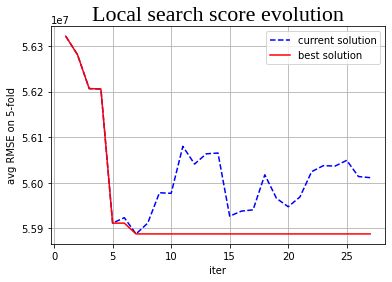

In [66]:
import matplotlib.font_manager as font_manager

current_scores = np.array(localsearch.curr_score)
best_scores = np.array(localsearch.best_score)
iter = np.arange(1, len(current_scores)+1)
plt.plot(iter, -current_scores, label="current solution", color="blue", linestyle="--")
plt.plot(iter, -best_scores, label="best solution", color="red")
title_font = font_manager.FontProperties(family="Liberation Serif", size=22)
plt.title("Local search score evolution", fontproperties=title_font)
plt.ylabel("avg RMSE on 5-fold")
plt.xlabel("iter")
plt.legend()
plt.grid()
plt.savefig("LS_Ridge_RMSE")

In [30]:
hello ?

SyntaxError: ignored

### GridSearch on RandomForestRegressor

In [ ]:
## GridSearch
# Définir les valeurs à tester pour les hyperparamètres du modèle
params =    {"n_estimators": [500], 
            "criterion": ["squared_error"], # ["squared_error", "absolute_error", "poisson"],
            "max_depth": [1],               # [None, 1, 2, 3],
            "min_samples_split": [1.0],       # [1, 2, 3],
            "max_features" : ["sqrt"],      # ["sqrt", "log2", None]
            }
rfr = RandomForestRegressor(n_jobs=-1,random_state=0)
grid = perform_grid_search(rfr, params, custom_scorer, X_train, y_train)


model = RandomForestRegressor(n_estimators = 500, 
                                criterion = "squared_error", # ["squared_error", "absolute_error", "poisson"],
                                max_depth = 1,               # [None, 1, 2, 3],
                                min_samples_split = 1.0,       # [1, 2, 3],
                                max_features = "sqrt",      # ["sqrt", "log2", None]
                                n_jobs=-1,
                                random_state=0)
model.fit(X_train, y_train)
model.predict(X_test)

# Évaluez le modèle en utilisant le scoreur personnalisé
score = custom_scorer(model, X_test, y_test)
print("\nRMSE Score: %.2f$" % score)
print("Score: %.2f%%" %model.score(X_test, y_test))

# Évaluez le modèle en utilisant le cross_val
rmse_score = cross_val_score(model, preprocessed_data, Y1.values.ravel(), cv=5,scoring=custom_scorer)
cv_regressor_score = cross_val_score(model, preprocessed_data, Y1.values.ravel(), cv=5)
print("\nCV RMSE Score : %.2f$" % np.mean(rmse_score))
print("CV Score : %.2f%%" % np.mean(cv_regressor_score))

### GridSearch on KNN

In [ ]:
## GridSearch
# Définir les valeurs à tester pour les hyperparamètres du modèle
params =    {'n_neighbors' : range(1, 50), 
            'weights' : ['uniform', 'distance']}
knn = KNeighborsRegressor(n_jobs=-1)
grid = perform_grid_search(knn, params, custom_scorer, X_train, y_train)

# CHECK LES RESULTATS
model = KNeighborsRegressor(n_neighbors= 43, weights= 'uniform', n_jobs=-1)
model.fit(X_train, y_train)
model.predict(X_test)

# Évaluez le modèle en utilisant le scoreur personnalisé
score = custom_scorer(model, X_test, y_test)
print("RMSE Score: %.2f$" % score)
print("Score: %.2f%%" %model.score(X_test, y_test))

# Évaluez le modèle en utilisant le cross_val
rmse_score = cross_val_score(model, preprocessed_data, Y1.values.ravel(), cv=5,scoring=custom_scorer)
knn_regressor_score = cross_val_score(model, preprocessed_data, Y1.values.ravel(), cv=5)
print("\nCV RMSE Score : %.2f$" % np.mean(rmse_score))
print("CV Score : %.2f%%" % np.mean(knn_regressor_score))

### Grid on MLP

In [ ]:
from sklearn.neural_network import MLPRegressor

params =    {'hidden_layer_sizes' : [(50,50,50), (100,5), (100,)],
            'activation' : ['relu'],
            'solver': ['adam'],
            'alpha' : np.linspace(0.0001, 0.001, 10, endpoint = True),
            'learning_rate_init': [0.001, 0.01, 0.1],
            'max_iter': [500]}
model = MLPRegressor(random_state=0)

grid = perform_grid_search(model, params, custom_scorer, X_train, y_train)

### Training on MLP

In [ ]:
model = MLPRegressor(activation = 'relu', 
                    alpha = 0.0007, 
                    hidden_layer_sizes = (50, 50, 50), 
                    learning_rate_init = 0.1, 
                    max_iter = 500, 
                    solver = 'adam',
                    random_state=0)

model.fit(X_train, y_train)
model.predict(X_test)

# Évaluez le modèle en utilisant le scoreur personnalisé
score = custom_scorer(model, X_test, y_test)
print("RMSE Score: %.2f$" % score)
print("Score: %.2f%%" % model.score(X_test, y_test))

# Évaluez le modèle en utilisant le cross_val
rmse_score = cross_val_score(model, preprocessed_data, Y1.values.ravel(), cv=5,scoring=custom_scorer)
mlp_regressor_score = cross_val_score(model, preprocessed_data, Y1.values.ravel(), cv=5)
print("\nCV RMSE Score : %.2e$" % np.mean(rmse_score))
print("CV Score : %.2f%%" % np.mean(mlp_regressor_score))

In [ ]:
# Score for each training subset
N, train_score, val_score = learning_curve(model, X_train, y_train, cv=5)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel("train size")
plt.legend()
plt.show()

In [ ]:
# Evaluation metrics from the gridsearch
res = pd.DataFrame(grid.cv_results_.values(), ).transpose()
res.columns=grid.cv_results_.keys()
res

## Neural network creation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(create_preprocessed(localsearch.best_solution.params), Y1, test_size=0.2)


In [ ]:
import torch

# Define the number of inputs and outputs
input_size = len(X_train.columns)
output_size = 1

# Define the number of hidden layers and the size of each layer
num_hidden_layers = 2
hidden_layer_size = 100

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the MLP model
model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_layer_size),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(hidden_layer_size, output_size)
).to(device)

model = model.double()

# Define the loss function and the optimizer
loss_fn = torch.nn.MSELoss()

lr = 1e-3
betas = (0.9, 0.999)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

# Define the number of epochs
num_epochs = 10

# Get the inputs and outputs as numpy arrays
inputs = X_train.to_numpy()
targets = y_train.to_numpy()

# Convert the inputs and targets to PyTorch tensors
inputs = torch.from_numpy(inputs).to(device).double()
targets = torch.from_numpy(targets).to(device).double()




# Train the model on a dataset of input-output pairs
for epoch in range(num_epochs):
    train_loss = []

    # Split the dataset into batches of the specified size
    for i in range(0, len(inputs)):
        # Get the inputs and targets for the current batch
        batch_inputs = inputs[i]
        batch_targets = targets[i]

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model.forward(batch_inputs)

        # Compute and print the loss
        loss = loss_fn(outputs, batch_targets)

        # Add the loss to the list of train losses
        train_loss.append(loss)

        # Zero the gradients before running the backward pass
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to the model parameters
        loss.backward()

        # Call the optimizer to update the model parameters
        optimizer.step()

    # Print the average train loss for the current epoch
    print(f"Epoch {epoch+1}: Train Loss = {torch.sqrt(sum(train_loss)/len(train_loss))}")

In [ ]:
inputs_test = X_test.to_numpy()
inputs_test = torch.from_numpy(inputs_test).to(device).double()
targets_test = y_test.to_numpy()
targets_test = torch.from_numpy(targets_test).to(device).double()

outputs_test = model.forward(inputs_test)
outputs_test = outputs_test.cpu().detach().numpy()
print("{:.2e} is the final error".format(compute_rmse(outputs_test, y_test)))